In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import corner.corner

from impulse.base import PTSampler

# test model things:
from test_model import make_sin_data, LnLikelihood, LnPrior

In [2]:
x, data, omega_real, a_real, phi_real = make_sin_data(1000)

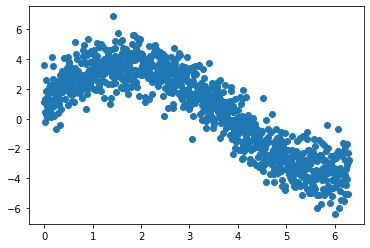

In [3]:
plt.scatter(x, data)

In [4]:
like = LnLikelihood(x, data)
prior = LnPrior([0, 0, 0], [3, 5, np.pi])

In [5]:
x0 = prior.initial_sample()
ndim = len(x0)

In [6]:
x0

array([2.13456781, 1.12433189, 2.07183417])

In [20]:
ntemps = 4
sampler = PTSampler(ndim, like, prior, ntemps=ntemps, adapt=True, tinf=True)

In [21]:
x0 = np.vstack([prior.initial_sample() for i in range(ntemps)])
chain = sampler.sample(x0, num_samples=100_000, thin=1, ret_chain=True)

  0%|          | 0/100000 [00:00<?, ?it/s]/Users/aaron/Documents/GitHub/impulse_mcmc/impulse/ptsampler.py:76: RuntimeWarning: overflow encountered in exp
  acc_ratio = np.exp(log_acc_ratio)
 72%|███████▏  | 72000/100000 [00:35<00:11, 2357.09it/s]/Users/aaron/Documents/GitHub/impulse_mcmc/impulse/proposals.py:253: RuntimeWarning: invalid value encountered in double_scalars
  q[groups[jumpind][ii]] += scale * sigma
/Users/aaron/Documents/GitHub/impulse_mcmc/impulse/mhsampler.py:59: RuntimeWarning: invalid value encountered in double_scalars
  lnprob_star = 1 / temp * lnlike_star + lnprior_star
100%|██████████| 100000/100000 [00:47<00:00, 2114.36it/s]


In [22]:
burn = int(0.25 * chain.shape[0])
omega = np.median(chain[burn:, 0, 0])
a = np.median(chain[burn:, 1, 0])
phi = np.median(chain[burn:, 2, 0])

In [23]:
print(omega, omega_real)
print(a, a_real)
print(phi, phi_real)

0.7340739688761305 0.7360712352514645
3.6748920204509266 3.713929302409257
0.322736913968617 0.3217522589350493


In [24]:
with open('./chains/temp_data/temps.txt', 'r') as f:
    temps = np.loadtxt(f)

with open('./chains/temp_data/accept.txt', 'r') as f:
    accept = np.loadtxt(f)

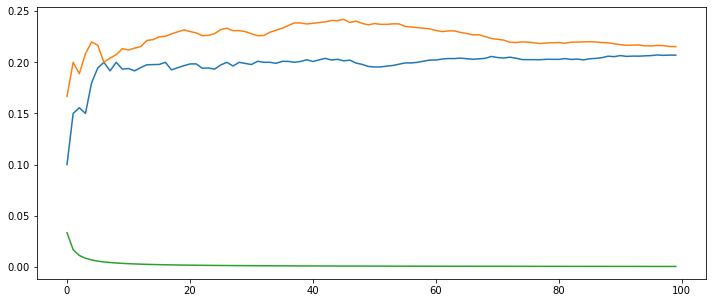

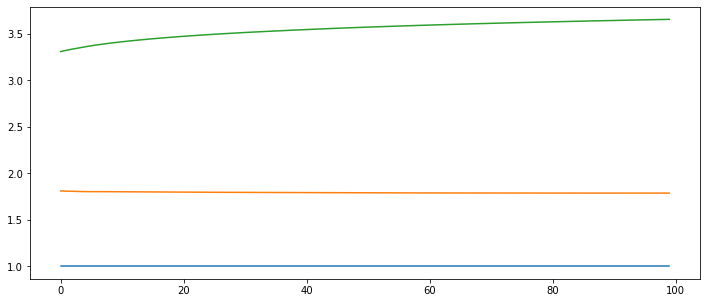

In [25]:
plt.figure(figsize=(12, 5))
for ii in range(ntemps - 1):
    # plt.plot(temps[:, ii])
    plt.plot(accept[:, ii])
plt.show()

plt.figure(figsize=(12, 5))
for ii in range(ntemps - 1):
    plt.plot(temps[:, ii])
    # plt.plot(accept[:, ii])
plt.show()

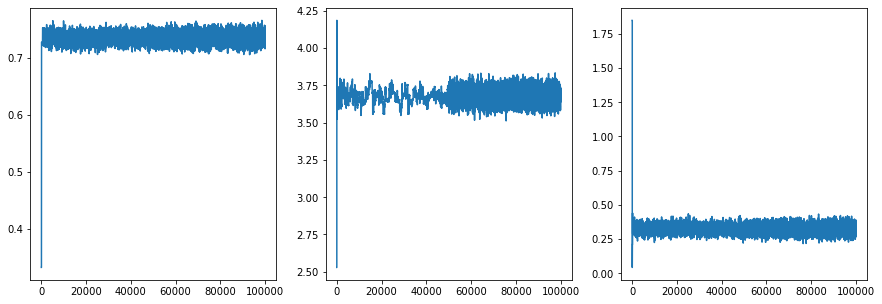

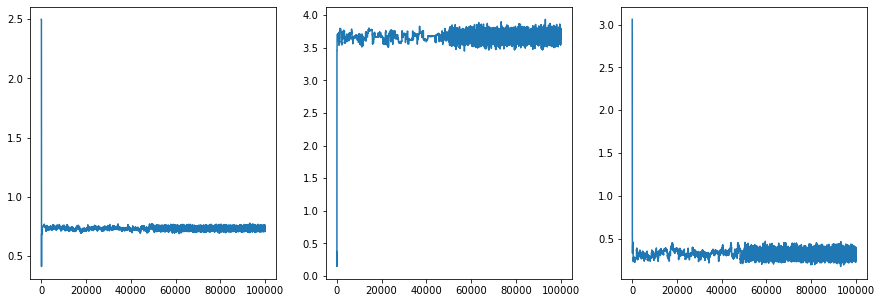

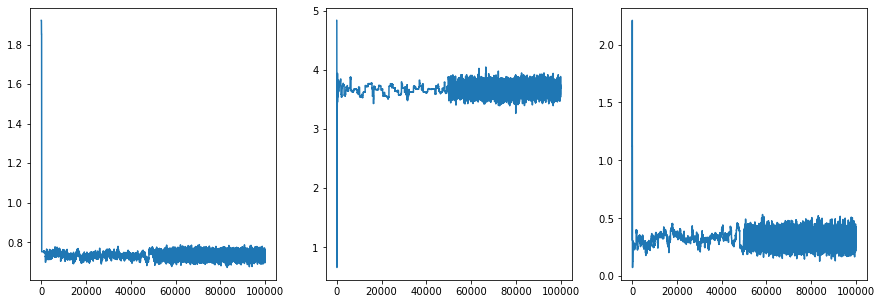

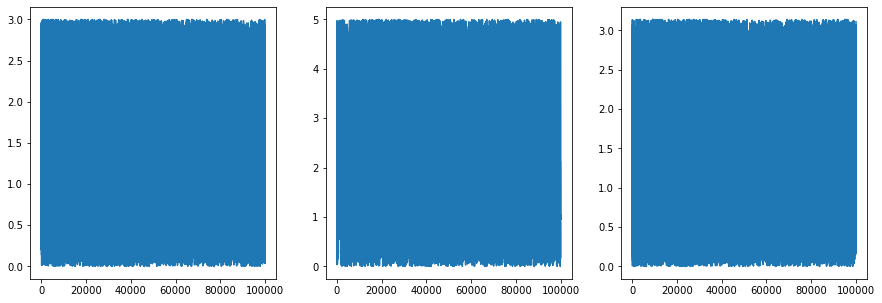

In [26]:
for ii in range(ntemps):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(chain[:, 0, ii])
    ax[1].plot(chain[:, 1, ii])
    ax[2].plot(chain[:, 2, ii])
    plt.show()

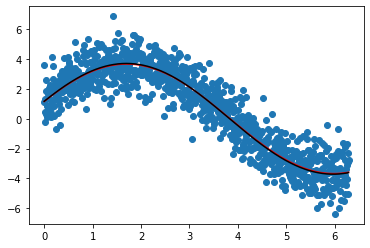

In [27]:
plt.scatter(x, data)
plt.plot(x, a * np.sin(omega * x + phi), color='red')
plt.plot(x, a_real * np.sin(omega_real * x + phi_real), color='black')

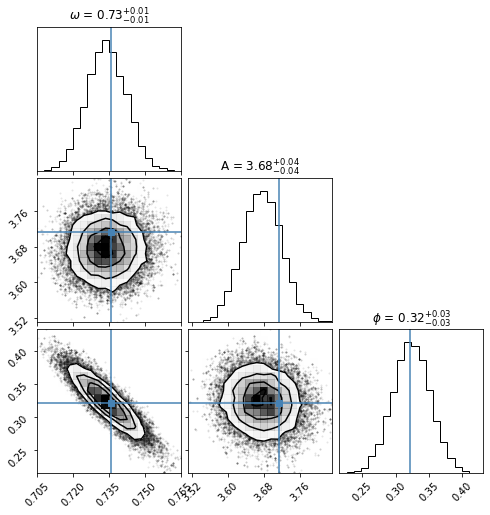

In [28]:
corner.corner(chain[2 * burn:, :, 0], truths=[omega_real, a_real, phi_real],
              titles=[r'$\omega$', r'A', r'$\phi$'], show_titles=True)
plt.show()

In [29]:
print(omega_real, a_real, phi_real)
print(omega, a, phi)

0.7360712352514645 3.713929302409257 0.3217522589350493
0.7340739688761305 3.6748920204509266 0.322736913968617


In [30]:
sampler.ptswap.compute_accept_ratio()

array([0.207     , 0.21533333, 0.00033333])

In [31]:
sampler.ptswap.adapt_ladder()

In [32]:
sampler.ptswap.ladder

array([1.        , 1.78844903, 3.65848449,        inf])